In [13]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import itertools
import paho.mqtt.client as mqtt

In [120]:
import time
import paho.mqtt.client as mqtt
import pickle
import json

# The callback for when the client receives a CONNACK response from the server.
def on_connect(client, userdata, flags, rc):
    print("Connected with result code "+str(rc))

    # Subscribing in on_connect() means that if we lose the connection and
    # reconnect then subscriptions will be renewed.
    client.subscribe("model")

    person_pkl = open('./files/COCO/personimages.pkl', 'rb')
    person_matrix = pickle.load(person_pkl)
    client.publish("data", "hello world")
    client.publish("data", "hello world")
    
# The callback for when a PUBLISH message is received from the server.
def on_message(client, userdata, msg):
    print(msg.topic+" "+str(msg.payload))

def on_publish(client, userdata, result):
    print("data published")

client = mqtt.Client()
client.on_publish = on_publish
client.on_connect = on_connect
client.on_message = on_message

client.connect("localhost", 1883, 65534)

# Blocking call that processes network traffic, dispatches callbacks and
# handles reconnecting.
# Other loop*() functions are available that give a threaded interface and a
# manual interface.
client.loop_forever()

Connected with result code 0
data published
data published


KeyboardInterrupt: 

In [121]:
import base64

def convertImageToBase64(to_encode):
     encoded = base64.b64encode(to_encode)
     return encoded

In [122]:
import random, string

def randomword(length):
     return ''.join(random.choice(string.ascii_lowercase) for i in range(length))

In [131]:
import math

packet_size=3000

def publishEncodedImage(encoded):
     end = packet_size
     start = 0
     length = len(encoded)
     picId = randomword(8)
     pos = 0
     no_of_packets = math.ceil(length/packet_size)

     while start <= len(encoded):
         data = {"data": encoded[start:end].decode('utf-8'), "pic_id":picId, "pos": pos, "size": no_of_packets}
         thing = json.dumps(data)
         client.publish("data", thing)
         end += packet_size
         start += packet_size
         pos = pos +1
     client.publish("data", "done")

In [137]:
image == image.decode('utf-8').encode()

True

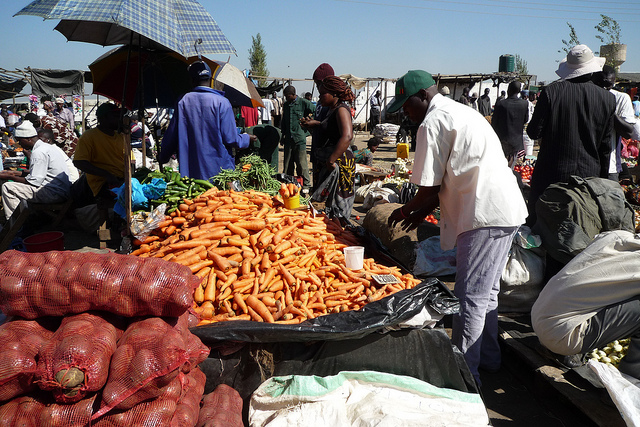

In [107]:
r = base64.b64decode(image)
q = np.frombuffer(r, dtype=np.uint8)
Image.fromarray(np.reshape(q, (427, 640, 3)))

In [106]:
sample[0].shape

(427, 640, 3)

In [167]:
person_pkl = open('./files/COCO/personimages.pkl', 'rb')
matrix = person_pkl.read()
image = convertImageToBase64(matrix)

In [151]:
with open("./my_small_pickle.pkl", "wb") as f:
    pickle.dump(matrix[0], f)

In [153]:
my_small_pickle = open('./my_small_pickle.pkl', 'rb')
person_matrix = my_small_pickle.read()
image = convertImageToBase64(person_matrix)

In [164]:
f = open("../server/my_pickle.pkl", "rb")
pickle.load(f)

(array([[[111, 150, 193],
         [107, 149, 191],
         [105, 149, 188],
         ...,
         [115, 153, 189],
         [114, 154, 189],
         [115, 156, 188]],
 
        [[109, 150, 194],
         [108, 150, 192],
         [108, 150, 192],
         ...,
         [113, 153, 189],
         [110, 153, 187],
         [110, 153, 187]],
 
        [[108, 151, 194],
         [108, 149, 193],
         [111, 150, 193],
         ...,
         [118, 157, 188],
         [117, 156, 187],
         [116, 157, 189]],
 
        ...,
 
        [[120,  41,  26],
         [138,  66,  52],
         [141,  63,  50],
         ...,
         [247, 251, 252],
         [250, 254, 255],
         [249, 253, 254]],
 
        [[121,  42,  25],
         [135,  67,  48],
         [131,  52,  35],
         ...,
         [247, 251, 252],
         [251, 255, 255],
         [248, 252, 253]],
 
        [[124,  45,  28],
         [133,  65,  42],
         [132,  51,  30],
         ...,
         [243, 247, 248],
  

In [168]:
publishEncodedImage(image)

<class 'bytes'>
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publ

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data published
data publi

In [ ]:
person_pkl = open('./files/COCO/personimages.pkl', 'rb')
person_matrix = person_pkl.read()
image = convertImageToBase64(person_matrix)
image

In [ ]:
typ

In [87]:
Image.fromarray(sample[0])

(427, 640, 3)

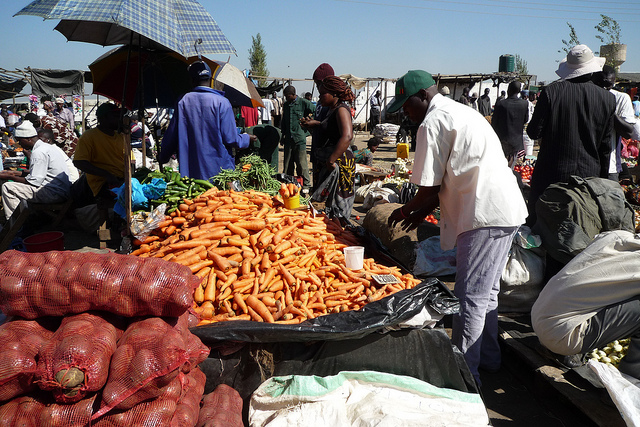

In [38]:
from PIL import Image
Image.fromarray(sample[0])

In [2]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [19]:
batch_size_train=60
batch_size_test=1000

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(root='./files', train=True, download=True, 
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize((0.1307, ), (0.3081,))
                               ])),
    batch_size=batch_size_train, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files', train=False, download=True,
                              transform=torchvision.transforms.Compose([
                                  torchvision.transforms.ToTensor(),
                                  torchvision.transforms.Normalize((0.1307,), (0.3081,))
                              ])),
    batch_size=batch_size_test, shuffle=True
)

In [3]:
dataset = torchvision.datasets.MNIST(root='./files', train=True, download=True, 
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize((0.1307, ), (0.3081,))
                               ]))

In [4]:
dataset[1]

(tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.424

In [21]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [22]:
example_data.shape

torch.Size([1000, 1, 28, 28])

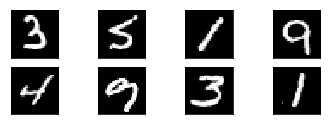

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure()

for i in range(8):
    plt.subplot(4,4,i+1)
    plt.imshow(example_data[i][0], cmap="gray", interpolation="none")
    plt.xticks([])
    plt.yticks([])

plt.show()

## Build Network

In [24]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    


## Initalize Network and Optimizer

In [26]:
learning_rate = 0.01
epochs = 3
log_interval = 10


network = Net().to("cpu")
optimizer = optim.SGD(network.parameters(), lr=learning_rate)

## Training Model

In [47]:
def train(device):
    network.train() #set network to training mode
        
    batch_idx = -1
    for (data, target) in itertools.islice(train_loader, 20):
        batch_idx += 1
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        print('Train Epoch: {} [{}/{} ({:.2f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()
        ))

## Test Function

In [45]:
test_losses = []

def test(device):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in itertools.islice(test_loader, 100):
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

## Test with CPU

In [48]:
import time
start_time = time.time()

test("cpu")
for epoch in range(epochs):
    train("cpu")
    test("cpu")
    
print("CPU took %s seconds" % (time.time() - start_time))

/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/pi/.local/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.2780, Accuracy: 1676/10000 (16%)

Train Epoch: 0 [0/60000 (0.00%)]	Loss: 2.292901
Train Epoch: 0 [60/60000 (0.10%)]	Loss: 2.278861
Train Epoch: 0 [120/60000 (0.20%)]	Loss: 2.289899
Train Epoch: 0 [180/60000 (0.30%)]	Loss: 2.265180
Train Epoch: 0 [240/60000 (0.40%)]	Loss: 2.282387
Train Epoch: 0 [300/60000 (0.50%)]	Loss: 2.273142
Train Epoch: 0 [360/60000 (0.60%)]	Loss: 2.255084
Train Epoch: 0 [420/60000 (0.70%)]	Loss: 2.260707
Train Epoch: 0 [480/60000 (0.80%)]	Loss: 2.267540
Train Epoch: 0 [540/60000 (0.90%)]	Loss: 2.273759
Train Epoch: 0 [600/60000 (1.00%)]	Loss: 2.261919
Train Epoch: 0 [660/60000 (1.10%)]	Loss: 2.266442
Train Epoch: 0 [720/60000 (1.20%)]	Loss: 2.254170
Train Epoch: 0 [780/60000 (1.30%)]	Loss: 2.267563
Train Epoch: 0 [840/60000 (1.40%)]	Loss: 2.286077
Train Epoch: 0 [900/60000 (1.50%)]	Loss: 2.272125
Train Epoch: 0 [960/60000 (1.60%)]	Loss: 2.279553
Train Epoch: 0 [1020/60000 (1.70%)]	Loss: 2.278034
Train Epoch: 0 [1080/60000 (1.80%)]	Loss: 2.